# Result reproduction

In [274]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn

#np.random.seed(32)

from MyDataset import IndianPines, PaviaUniversity, PaviaCenter
from SSGA import SSGA

In [275]:
usedDataset = IndianPines
#usedDataset = PaviaUniversity
#usedDataset = PaviaCenter

145 145 200
82


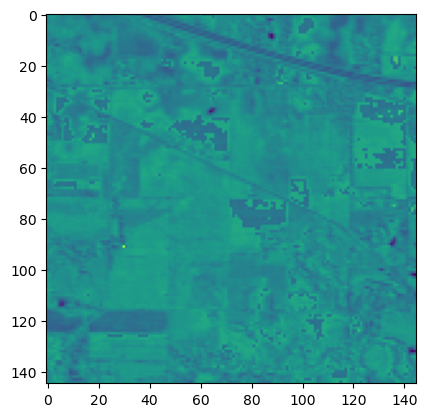

In [276]:
n,m,B = usedDataset["shape"]
print(n,m,B)
b = np.random.randint(0, B-1)
print(b)
plt.imshow(usedDataset["data"][:,:,b])
plt.show()

In [277]:
from EntropyRateSuperpixel import find_superpixel, complete_basic_similarity, plot_img_with_borders, complete_norm_similarity, create_overlay_borders

K = 300
# Try not to get to small superpixel size
# Dataset, K, coeff
IndianCoeffSP1 = {200:34, 300:48}
# PaviaUniversity : (300, 24)
SP = find_superpixel(usedDataset["data"], K, IndianCoeffSP1[K], complete_basic_similarity, True)
SP1_overlay = create_overlay_borders(usedDataset["data"][:,:,0], SP)
l = [len(l) for l in SP]
l.sort()
print(l)

[35, 42, 42, 43, 44, 44, 45, 45, 45, 46, 46, 47, 47, 47, 47, 47, 47, 48, 48, 48, 49, 49, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 51, 52, 52, 52, 52, 52, 53, 53, 53, 53, 53, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 56, 56, 56, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 62, 62, 62, 62, 62, 62, 63, 63, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 69, 69, 69, 69, 70, 70, 70, 70, 70, 70, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 74, 74, 74, 74, 74, 75, 75, 75, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 80, 80, 81, 81, 81, 82, 82, 82, 83, 83, 83, 83, 84, 84, 84, 84, 85, 85, 85, 85, 85, 86, 86, 86, 87, 87, 87, 88, 88, 88, 88,

In [278]:
IndianCoeffSP2 = {200:100, 300:160}
# PaviaUniversity : (300, 180)
SP2 = find_superpixel(usedDataset["data"], K, IndianCoeffSP2[K], complete_norm_similarity, True)
# A bit faster, why?
SP2_overlay = create_overlay_borders(usedDataset["data"][:,:,0], SP2)
l = [len(l) for l in SP2]
l.sort()
print(l)

[7, 17, 21, 24, 25, 29, 30, 31, 32, 34, 35, 38, 40, 41, 41, 42, 42, 43, 43, 43, 43, 44, 44, 44, 44, 45, 45, 45, 45, 45, 45, 46, 47, 49, 49, 50, 50, 50, 50, 51, 51, 51, 51, 52, 52, 52, 53, 53, 53, 53, 54, 54, 54, 54, 54, 54, 54, 54, 55, 55, 55, 55, 55, 55, 56, 56, 56, 56, 57, 57, 57, 57, 57, 57, 57, 57, 57, 58, 58, 58, 58, 58, 58, 58, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 59, 60, 60, 60, 60, 60, 60, 60, 60, 60, 61, 61, 61, 61, 61, 61, 61, 61, 62, 62, 62, 63, 63, 63, 63, 63, 64, 64, 64, 64, 64, 65, 65, 65, 65, 65, 66, 66, 66, 66, 67, 67, 67, 67, 67, 68, 68, 68, 68, 68, 68, 69, 69, 69, 69, 69, 69, 70, 70, 70, 71, 71, 71, 71, 71, 71, 71, 71, 72, 72, 72, 72, 72, 73, 73, 73, 73, 73, 73, 73, 73, 73, 74, 74, 75, 75, 75, 75, 75, 75, 75, 76, 76, 76, 76, 76, 76, 76, 76, 77, 77, 77, 77, 77, 77, 78, 78, 78, 79, 79, 79, 79, 79, 80, 80, 80, 80, 81, 81, 81, 82, 82, 82, 82, 82, 82, 83, 83, 83, 83, 83, 84, 84, 84, 85, 85, 85, 85, 85, 86, 86, 86, 86, 86, 87, 87, 87, 87, 88, 88, 89, 89, 89, 89, 89, 

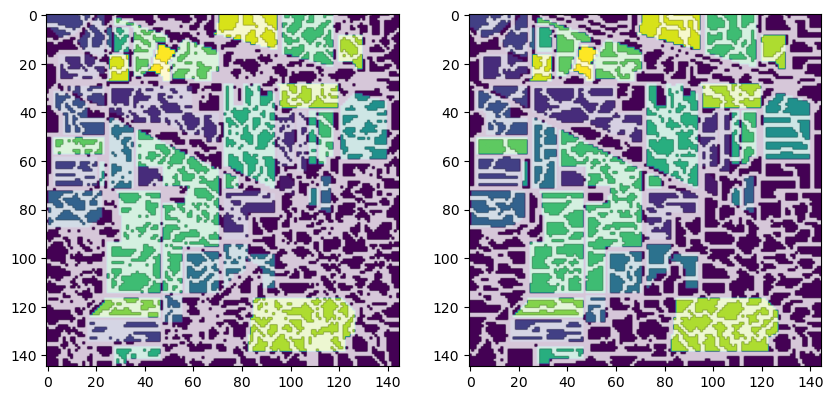

In [279]:
b = np.random.randint(0, B-1)
fig, axs = plt.subplots(1,2)
fig.set_size_inches(10,20)

overlays = [SP1_overlay, SP2_overlay]
color = [255,255,255,200]
for k in range(len(overlays)):
    for i in range(n):
        for j in range(m):
            if overlays[k][i,j][3] != 0:
                overlays[k][i,j] = color
    
    axs[k].imshow(usedDataset["gt"])
    axs[k].imshow(overlays[k])

plt.show()

In [280]:
SP_used = SP
#SP_used = SP2

0.8525836593571147
0.8442722954169981
0.8457748454801368
0.8478613800902786
0.8480817430438261
0.8490400597639685
0.8550806080985991
0.8476036509186663
0.8523894459532811
0.839959718987772


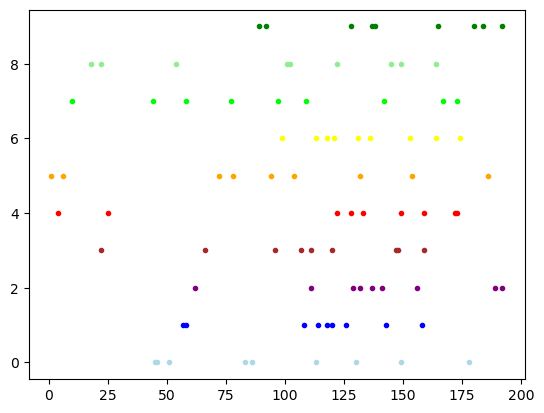

In [281]:
class Param:
    GN = 100
    NP = 100
    Pc = 0.9
    Pm1 = 0.02
    Pm2 = 0.1

N = 10
colors = ["lightblue", "blue", "purple", "brown", "red", "orange", "yellow", "lime", "lightgreen", "green"]
best_indiv = None
best_fitness = 0
for j in range(N):
    pop, fitness = SSGA(usedDataset["data"], 9, K, Param.GN, Param.NP, Param.Pc, Param.Pm1, Param.Pm2, False, SP=SP_used)
    if fitness[0]>best_fitness:
        best_indiv = pop[0]
        best_fitness = fitness[0]
    print(fitness[0])
    for i,b in enumerate(pop[0]):
        if b==1:
            plt.plot(i,j, ".", color=colors[j])
plt.show()

# Select samples

In [282]:
import sklearn.utils

def split_data(dataset, percent, bands):
    for_slices = [i for i in range(len(bands)) if bands[i]==1]
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    nb_info = sum([len(liste) for key,(_,liste) in dataset["class"].items() if key!=0])
    weights = {}
    for key, (name, liste) in dataset["class"].items():
        if key !=0:
            indices = np.zeros(len(liste), dtype=int)
            indices[:int(len(liste)*percent)] = 1
            weights[key] = nb_info/ len(liste)
            print(key, name, int(len(liste)*percent), len(liste), len(liste)/nb_info)
            
            for i in range(len(liste)):
                data = dataset["data"][liste[i]]
                if indices[i]==1:
                    X_train.append(data[for_slices])
                    y_train.append(key)
                else:
                    X_test.append(data[for_slices])
                    y_test.append(key)

    X_train, y_train = sklearn.utils.shuffle(X_train, y_train, random_state=42)
    X_test, y_test = sklearn.utils.shuffle(X_test, y_test, random_state=42)

    return np.array(X_train), np.array(y_train), np.array(X_test), np.array(y_test), weights
   
    

best_paper_indiv = [0 for _ in range(B)]
indian_best_index = [16, 28, 31, 38, 71, 83, 113, 128, 162]
university_best_index = [18, 33, 47, 64, 69, 72, 67, 83, 85]
center_best_index = [16, 37, 44, 66, 74, 83, 85, 97, 101]
for i in indian_best_index:
    best_paper_indiv[i] = 1

from SSGA import fitness_function, compute_Sbsp_Stsp_list
#Sbsp_list, Stsp_list = compute_Sbsp_Stsp_list(usedDataset["data"], SP)
#print(fitness_function(best_paper_indiv, Sbsp_list, Stsp_list))



bands=best_indiv
#bands=best_paper_indiv
#bands=[1 for _ in range(B)]
X_train,y_train, X_test,y_test, weights = split_data(usedDataset, 0.05, bands)
print(X_train.shape, X_test.shape)
print(weights)

1 Alfalfa 2 46 0.00448824275539077
2 Corn-notill 71 1428 0.13933066640647868
3 Corn-mintill 41 830 0.08098351058639867
4 Corn 11 237 0.023124207239730705
5 Grass-pasture 24 483 0.047126548931603084
6 Grass-trees 36 730 0.07122646111815786
7 Grass-pasture-mowed 1 28 0.002731973851107425
8 Hay-windrowed 23 478 0.04663869645819104
9 Oats 1 20 0.0019514098936481608
10 Soybean-notill 48 972 0.09483852083130062
11 Soybean-mintill 122 2455 0.23953556444531174
12 Soybean-clean 29 593 0.057859303346667966
13 Wheat 10 205 0.020001951409893647
14 Woods 63 1265 0.12342667577324618
15 Buildings-Grass-Trees-Drives 19 386 0.03766221094740951
16 Stone-Steel-Towers 4 93 0.009074056005463947
(505, 9) (9744, 9)
{1: 222.80434782608697, 2: 7.177170868347339, 3: 12.348192771084337, 4: 43.244725738396625, 5: 21.21946169772257, 6: 14.03972602739726, 7: 366.0357142857143, 8: 21.44142259414226, 9: 512.45, 10: 10.544238683127572, 11: 4.174745417515275, 12: 17.283305227655987, 13: 49.99512195121951, 14: 8.1019762

# Sklearn SVM

In [283]:
from sklearn import svm
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

pipeline = Pipeline([
    ('scalar', StandardScaler()),
    ('svc', svm.SVC(kernel='rbf'))
])

param_grid = {
    'svc__C': [0.1, 1, 10, 100, 1000, 2000, 4000],
    'svc__gamma': [1, 0.1, 0.01, 0.001, 0.0005, 0.0001],

    #'svc__C': [10, 50, 75, 100, 150],
    #'svc__gamma': [1, 0.75, 0.5, 0.25, 0.01]
}

clf = svm.SVC(kernel="rbf", C=1.0, gamma="scale")#, class_weight="balanced")
#clf = svm.SVC(kernel="rbf", C=2**32, gamma=3.0517578125e-05)#, class_weight="balanced")

clf = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(y_pred.tolist())
print("Accuracy =", len([0 for i in range(len(y_pred)) if y_pred[i]==y_test[i]])/len(y_pred))

print(clf.get_params())
print(clf.best_estimator_.get_params())

/usr/lib/python3/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


[10, 4, 14, 10, 5, 14, 14, 11, 4, 2, 10, 3, 2, 10, 2, 5, 13, 10, 2, 1, 2, 5, 5, 10, 2, 2, 4, 4, 2, 4, 2, 2, 2, 14, 2, 2, 3, 2, 5, 2, 11, 14, 2, 2, 12, 14, 2, 1, 2, 14, 6, 4, 14, 14, 3, 2, 2, 2, 14, 2, 4, 8, 2, 14, 2, 1, 11, 6, 2, 14, 8, 5, 10, 8, 14, 6, 8, 11, 4, 2, 2, 2, 10, 2, 2, 2, 2, 4, 3, 6, 14, 10, 3, 4, 5, 2, 6, 14, 3, 14, 4, 2, 2, 3, 11, 11, 2, 4, 2, 5, 3, 2, 14, 4, 6, 4, 2, 2, 6, 2, 2, 14, 13, 14, 2, 4, 2, 11, 2, 1, 2, 2, 10, 3, 14, 5, 6, 2, 2, 14, 11, 14, 2, 10, 3, 11, 4, 14, 6, 10, 4, 3, 10, 10, 2, 1, 2, 7, 6, 2, 11, 3, 10, 2, 2, 13, 11, 14, 10, 2, 10, 2, 14, 2, 13, 2, 14, 2, 3, 10, 2, 2, 6, 14, 14, 14, 14, 11, 2, 6, 6, 3, 2, 3, 2, 2, 4, 2, 5, 11, 14, 2, 10, 8, 2, 4, 2, 14, 10, 2, 6, 2, 1, 2, 5, 6, 3, 2, 6, 2, 14, 14, 10, 2, 10, 4, 8, 3, 1, 8, 2, 10, 13, 14, 2, 3, 14, 16, 2, 14, 6, 6, 10, 10, 10, 2, 2, 2, 10, 10, 6, 2, 2, 2, 14, 8, 5, 11, 8, 2, 1, 6, 2, 14, 14, 2, 14, 11, 2, 14, 5, 3, 4, 2, 5, 14, 10, 10, 14, 2, 14, 4, 2, 2, 10, 2, 5, 14, 3, 6, 8, 14, 3, 3, 2, 5, 4, 2, 6, 8,

# LibSVM1 toolbox

https://www.csie.ntu.edu.tw/~cjlin/libsvm/

In [284]:
from libsvm.svmutil import svm_train, svm_predict, svm_parameter, svm_problem
from sklearn.model_selection import KFold

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Prepare cross-validation splits
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Parameters grid
C_values = [0.1, 1, 10, 100]
gamma_values = [1, 0.1, 0.01, 0.001]

best_score = 0
best_params = {}

for C in C_values:
    for gamma in gamma_values:
        accuracies = []
        for train_index, val_index in kf.split(X_scaled):
            X_train_cv, X_val_cv = X_scaled[train_index], X_scaled[val_index]
            y_train_cv, y_val_cv = y_train[train_index], y_train[val_index]

            # Create libsvm problem
            prob = svm_problem(y_train_cv.tolist(), X_train_cv.tolist())

            # Setup parameters string for libsvm
            param_str = f'-s 0 -t 2 -c {C} -g {gamma} -q'  
            # -s 0: C-SVC, -t 2: RBF kernel, -c: C, -g: gamma, -q: quiet mode

            param = svm_parameter(param_str)

            # Train model
            model = svm_train(prob, param)

            # Predict on validation fold
            p_label, p_acc, p_val = svm_predict(y_val_cv.tolist(), X_val_cv.tolist(), model, options='-q')

            accuracies.append(p_acc[0])  # p_acc is [accuracy, mean squared error, squared correlation]

        avg_acc = np.mean(accuracies)
        print(f"C={C}, gamma={gamma}, CV accuracy={avg_acc:.4f}")

        if avg_acc > best_score:
            best_score = avg_acc
            best_params = {'C': C, 'gamma': gamma}

print(f"Best CV accuracy: {best_score:.4f} with params {best_params}")


C=0.1, gamma=1, CV accuracy=57.2277
C=0.1, gamma=0.1, CV accuracy=46.9307
C=0.1, gamma=0.01, CV accuracy=36.6337
C=0.1, gamma=0.001, CV accuracy=24.1584
C=1, gamma=1, CV accuracy=73.8614
C=1, gamma=0.1, CV accuracy=60.9901
C=1, gamma=0.01, CV accuracy=47.5248
C=1, gamma=0.001, CV accuracy=36.6337
C=10, gamma=1, CV accuracy=84.1584
C=10, gamma=0.1, CV accuracy=78.4158
C=10, gamma=0.01, CV accuracy=59.6040
C=10, gamma=0.001, CV accuracy=47.5248
C=100, gamma=1, CV accuracy=81.7822
C=100, gamma=0.1, CV accuracy=84.5545
C=100, gamma=0.01, CV accuracy=79.6040
C=100, gamma=0.001, CV accuracy=59.2079
Best CV accuracy: 84.5545 with params {'C': 100, 'gamma': 0.1}


In [285]:
from libsvm.svmutil import *
from libsvm.svm import *


prob = svm_problem(y_train, X_train)

# "parameters C and gamma were optimized by fivefold cross-validation"

param = svm_parameter()
param.kernel_type = 2 #RBF  # Radial Basis Function kernel
param.C = 2**0.1 #best_params["C"]  # Cost parameter
param.gamma = 1/(n*m * X_train.var()) #best_params["gamma"]  # Kernel parameter

#param.nr_weight = len(weights.keys())
#param.weight_label = (c_double * len(weights))(*list(weights.keys()))
#param.weight = (c_double * len(weights))(*list(weights.keys()))


# 5-fold cross-validation
param.cross_validation = True
param.nr_fold = 5
accuracy = svm_train(prob, param)

# Train model
param.cross_validation = False
model = svm_train(prob, param)
p_labels, p_acc, p_vals = svm_predict(y_test, X_test, model)  
print(p_labels)
print(p_acc)

*
optimization finished, #iter = 29
nu = 0.456693
obj = -61.689958, rho = 0.977467
nSV = 58, nBSV = 58
*
optimization finished, #iter = 16
nu = 0.711111
obj = -34.250660, rho = -0.995805
nSV = 32, nBSV = 32
*
optimization finished, #iter = 29
nu = 0.674419
obj = -61.702797, rho = 0.973440
nSV = 58, nBSV = 58
*
optimization finished, #iter = 29
nu = 0.935484
obj = -61.657865, rho = 0.973651
nSV = 58, nBSV = 58
*
optimization finished, #iter = 29
nu = 0.725000
obj = -62.039706, rho = 0.992989
nSV = 58, nBSV = 58
*
optimization finished, #iter = 20
nu = 0.816327
obj = -42.782386, rho = -0.993463
nSV = 40, nBSV = 40
*
optimization finished, #iter = 29
nu = 0.852941
obj = -61.697503, rho = 0.979237
nSV = 58, nBSV = 58
*
optimization finished, #iter = 9
nu = 0.473684
obj = -19.200830, rho = -0.989121
nSV = 18, nBSV = 18
*
optimization finished, #iter = 24
nu = 0.905660
obj = -51.072125, rho = -0.980268
nSV = 48, nBSV = 48
*
optimization finished, #iter = 19
nu = 0.791667
obj = -40.532460, rh

In [286]:
def save_libsmv_data(path, X_train, y_train):
    f = open(path, "w")
    for i in range(len(y_train)):
        txt = str(y_train[i])
        for j in range(len(X_train[i])):
            txt += " " + str(j+1) + ":" + str(X_train[i,j])
        f.write(txt + "\n")
    f.close()

save_libsmv_data("libsvm_train_data.txt", X_train, y_train)
save_libsmv_data("libsvm_test_data.txt", X_test, y_test)

In [287]:
y_train_libsvm, X_train_svm = svm_read_problem('libsvm_train_data.txt')
y_test_libsvm, X_test_libsvm = svm_read_problem("libsvm_test_data.txt")
# Train the model (C-SVC with RBF kernel by default)
c=32.0
g=3.0517578125e-05
print('-c {} -g {}'.format(c,g))
model = svm_train(y_train_libsvm, X_train_svm, '-c {} -g {} '.format(c,g))

# Predict using the same training data (or test data)
p_label, p_acc, p_val = svm_predict(y_test_libsvm, X_test_libsvm, model)
print(p_label)

-c 32.0 -g 3.0517578125e-05
*
optimization finished, #iter = 36
nu = 0.455696
obj = -2293.589966, rho = 0.985700
nSV = 72, nBSV = 72
*
optimization finished, #iter = 19
nu = 0.690909
obj = -1215.048218, rho = -0.997353
nSV = 38, nBSV = 38
*
optimization finished, #iter = 36
nu = 0.672897
obj = -2292.595642, rho = 0.980763
nSV = 72, nBSV = 72
*
optimization finished, #iter = 36
nu = 0.935065
obj = -2293.268738, rho = 0.984423
nSV = 72, nBSV = 72
*
optimization finished, #iter = 36
nu = 0.727273
obj = -2300.995300, rho = 0.995456
nSV = 72, nBSV = 72
*
optimization finished, #iter = 24
nu = 0.800000
obj = -1534.031616, rho = -0.995932
nSV = 48, nBSV = 48
*
optimization finished, #iter = 36
nu = 0.857143
obj = -2294.133972, rho = 0.987782
nSV = 72, nBSV = 72
*
optimization finished, #iter = 11
nu = 0.468085
obj = -702.057739, rho = -0.993779
nSV = 22, nBSV = 22
*
optimization finished, #iter = 29
nu = 0.892308
obj = -1847.915527, rho = -0.988248
nSV = 58, nBSV = 58
*
optimization finished,